# RNN(Recurrent Neural Networks)
##### note: 用いられている図はインターネットから取得したもので、変数名等は統一されていません。

時系列データを扱うためには、一般的なディープラーニングのモデルではない、その扱いに特化したモデルが必要となります。そのようなモデルをリカレントニューラルネットワーク、または再起型ニューラルネットワークと呼びます。これはダイアグラムを見た方が直感的に、そして容易にその効果を理解できます。

<img src="https://qiita-image-store.s3.amazonaws.com/0/127228/ce02a73f-c2b0-2185-ba22-e3c2cab165af.jpeg"/>

これは一度データから得られた特徴量を保存して置いて、つぎに新しいデータが来たときにそれと合わせて分析しようという方法です。時刻$t$の入力データと時刻$t-1$の隠れ層の値を用いているのです。これの図をさらに時間の経過にしたがって書き直してみると、

<img src="http://functionp.com/wp-content/uploads/2016/03/195d5f31583b4269ee5ca938d2a56aac.png"/>


と表現できます。このようにしてモデルに時間の概念を導入しようとしているのです。

## 勾配消失問題

このように層が深いモデルでは勾配が消失してしまう問題があります。勾配の消失を説明する前に、活性化関数について説明しましょう。

入力$x_1$、$x_2$の単純パーセプトロン

<img src="https://i2.wp.com/developers.eure.jp/wp-content/uploads/2016/12/dl1.png?ssl=1"/>

の総電気信号量は

\begin{equation}
    w_1 x_1 + w_2 x_2 + \theta 
\end{equation}

で表現されました。これを

\begin{equation}
    w^T x + \theta 
\end{equation}
と表現します。

出力量は

\begin{cases}
    1 \ \ \ \ \ w_1 x_1 + w_2 x_2 \ge \theta \\
    0 \ \ \ \ \ w_1 x_1 + w_2 x_2 < \theta
\end{cases}

でした。したがって、出力$w^T x + \theta$についてステップ関数を用いて0または1に変換する必要があります。しかし、この重みと閾値を求めるためには、これらのパラメータを遂次的に更新していく方法を取ります。このような方法を勾配降下法と呼びますが、その際に勾配の偏微分を利用します。しかし、ステップ関数では偏微分が利用できないために、一般的にはシグモイド関数を用います。そして、このシグモイド関数のことを活性化関数と呼びます。

<img src="http://www.yuripapa.net/images/learn8.jpg"/>

このシグモイド関数の導関数

$$\sigma^`(x)=\sigma(x)(1-\sigma)$$は

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKei5hljeR79bVeCGO093RJquG_irA8SkCosqzBAlWg9DDiIou"/>

と表現できます。この導関数は$x=0$のときに最大値0.25を取ります。しかし、層の数が増え、その度に活性化関数を用いると、この勾配がどんどんなくなってしまいます。この現象を勾配消失問題と呼びます。

そして、長期の時間依存性は勾配消失問題のために求めることができないという問題がありました。

## LSTM(long short-term memory)

長期の時間依存性の問題を解決するために考えだされたのが、LSTMです。

### LSTMの特徴

LSTMではネットワークの構造を変えることで勾配消失問題を解決しようとしています。

##### CEC(constant error carousel)
線形活性化関数を使い、重み行列を単位行列とすることで勾配消失問題を回避できます。しかし、この場合には時間依存性のあるデータを受け取った時には学習がうまく行えません。それを入力重み衝突、出力重み衝突といいます。

##### 入力、出力ゲート
入力重み衝突、出力重み衝突の問題を解決しよう入力ゲートと出力ゲートが導入されています。これは過去のデータが必要になった時点でゲートを開けます。

##### 忘却ゲート
過去の必要な情報は内部で保持することは重要ですが、必要なくなったときに廃棄することも重要です。そのような役割を担うのが忘却ゲートです。

##### のぞき穴結合
CEC、入力ゲート、出力ゲートにより、短期・長期の時系列データの学習の効率は改善しましたが、たとえば、出力ゲートが閉じたままであるという問題も生じます。そのような時のために、それぞれのゲートの状態を確認する必要があります。それを可能にするのがのぞき穴結合です。


<img src="https://deepage.net/img/tflearn_rnn/Long_Short_Term_Memory.png"/>

<img src="https://deeplearning4j.org/img/greff_lstm_diagram.png"/>

<img src=""/>
<img src=""/>
<img src=""/>


https://www.youtube.com/watch?v=ftMq5ps503w

https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo

##### プログラムを動かすためにモジュールです。

In [4]:
%matplotlib inline
import time
import warnings
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import SimpleRNN
from keras.models import Sequential
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pandas_datareader.data as web
import pandas as pd
from datetime import datetime, date

Using TensorFlow backend.


## データをグーグルから取得しています。
##### 取得したデータをテストデータ(test)と学習用のデータ(train)に分割しています。

In [5]:
#Step 1 Load Data
tsd0 = web.DataReader("SPY","google","1990/1/1")
tsd = tsd0.Close.values

##### 訓練データとテストデータの作成

ステップ1: 全データをtime_windowの長さに分割する。  

ステップ2: 90%のデータが訓練データ、残りがテストデータとなります。

ステップ3: 学習用データをシャッフル。学習用データをさらに準備データ(x_train)と教師データ(y_train)に分けます。  

ステップ4: テストデータを準備データ(x_test)と教師データ(y_test)に分割。

最初のXのデータは0からtime_windowまでをひとつひつつずらしながらローリングしています。一方、yはtime_windowから最後までのデータです。そして、このような形で元のデータを作った後に、出来たデータをシャッフルしています。

time_window=50とすると、その最初の90%、つまり45個のデータを訓練データ、残りの5個をテストデータとしています。

In [6]:
def prepare_data(data, time_window,shuffling):
    data_length = time_window + 1
    data_div = []
    for index in range(len(data) - data_length):
        data_div.append(data[index: index + data_length])
    n_data = []
    for w in data_div:
        n_window = [((float(ww) / float(w[0])-1)) for ww in w]
        #n_window = [((float(ww))) for ww in w]
        n_data.append(n_window)
    data_div = np.array(n_data)

    row = round(0.9 * data_div.shape[0])
    train = data_div[:int(row), :]
    if shuffling:
        np.random.shuffle(train)
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test = data_div[int(row):, :-1]
    y_test = data_div[int(row):, -1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))  

    return [x_train, y_train, x_test, y_test]

In [7]:
#Step 2 
time_window=50
X_train, y_train, X_test, y_test = prepare_data(tsd, time_window,False)
print('no. of all data',len(tsd))
print('no. of train data X',len(X_train),'y',len(y_train))
print('no. of test data X',len(X_test),'y', len(y_test))
print(X_train.shape,y_train.shape)

no. of all data 4000
no. of train data X 3554 y 3554
no. of test data X 395 y 395
(3554, 50, 1) (3554,)


# MODEL
## model = sequencial    LSTM + Dense

##### retrurn_sequances

出力系列の最後の出力を返すか，完全な系列を返すか

##### Activation=linear 

活性化関数：linearなのでそのままと思われます？

#### model.compile

##### loss=mse

損失関数：mean square errors

##### optimizer=rmsprop

最適化関数：RNNのときの推奨最適化法

##### metrics=mae

In [8]:
#Step 3
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()

model.add(LSTM(
#model.add(SimpleRNN(
    input_shape=(None, 1), 
    units=50,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='mse', optimizer='rmsprop',metrics=['mae'])
print('compilation time : ', time.time() - start)

compilation time :  0.029520750045776367


### model.fit

##### validation_split

validation_split=0.05とすると，データの最後の5％が検証のために利用されます。0.1では，データの最後の10%が検証に使われます．
validation splitによるデータの抽出ではデータはシャッフルされません。したがって，入力データの 最後の x% のsampleに対して検証が行われます．

##### shuffle

shuffle=Trueと設定すれば、訓練データはシャッフルされます（初期値はTrue）。各epochで訓練データはランダムにシャッフルされますが、検証用データはシャッフルされません．

##### batch_size

prepare_dataにより、(全データ数－time_winodow)の数だけのtime_windowの長さの時系列データが作られている。これを500分割して、時系列データを抽出している。

##### return_sequences

真理値．出力系列の最後の出力を返すか，完全な系列を返すか．

In [6]:
#Step 4
t1=datetime.now()
model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=1,
    shuffle=False,
    validation_split=0.05,verbose=0)
print('execution time',datetime.now()-t1)

execution time 0:02:05.942982


###  Prediction

In [7]:
def predict_time_series_data(model, data, time_window, pred_window):
    #Predict sequence of pred_window steps before shifting prediction run forward by pred_window steps
    pred_seqs = []
    error=0
    for i in range(int(len(data)/pred_window+1)):
        curr_frame = data[i*pred_window]
        predicted = []
        for j in range(pred_window):
            pred=(model.predict(curr_frame[newaxis,:,:])[0,0])
            predicted.append(pred)
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [time_window-1], predicted[-1], axis=0)
            error+=(pred-data[i][j])**2
        pred_seqs.append(predicted)
    return pred_seqs,error

In [8]:
#Step 5 - Make the predictions!
pred_window=50
time_window=time_window
predictions,error = predict_time_series_data(model, X_test, time_window,pred_window)
print('residual squared error',error)
tsd0.Close.pct_change().std()

residual squared error [ 3.25894743]


0.011999255011721525

###  Plot

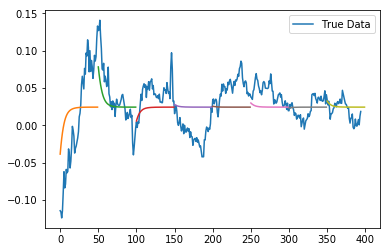

In [9]:
#Step 6 - Plot the prediction!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.legend()
for i, data in enumerate(predictions):
    padding = [None for p in range(i * pred_window)]
    plt.plot(padding + data)
plt.show()

# MODEL -- LSTM+LSTM+Dense

In [10]:
#Step 2 
time_window=50
X_train, y_train, X_test, y_test = prepare_data(tsd, time_window,False)
#Step 3
t1=datetime.now()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model = Sequential()

model.add(LSTM(
#model.add(SimpleRNN(
    input_shape=(None, 1), 
    units=50,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
#model.compile(loss='mse', optimizer='rmsprop')
model.compile(loss='mse', optimizer='rmsprop',metrics=['mae'])
print('compilation time : ', time.time() - start)

#Step 4
model.fit(
    X_train,
    y_train,
    batch_size=500,
    epochs=200,
    shuffle=False,
    validation_split=0.1,verbose=0)

#Step 5 - Make the predictions!
pred_window=50
time_window=time_window
predictions,error = predict_time_series_data(model, X_test, time_window,pred_window)
print("mean squared error",error)

#Step 6 - Plot the prediction!
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')
plt.legend()
for i, data in enumerate(predictions):
    padding = [None for p in range(i * pred_window)]
    plt.plot(padding + data)
plt.show()
t2=datetime.now()
print('execution time',t2-t1)

compilation time :  0.03401947021484375


NameError: name 'predict_time_series_data' is not defined